In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Utilisation de imblearn pour SMOTE dans la pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder # RobustScaler pour mieux gérer les outliers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

In [2]:
# 1. PRÉPARATION DES DONNÉES
df = pd.read_csv('train.csv')
X = df.drop(columns=['id', 'CustomerId', 'Surname', 'Exited'])
y = df['Exited']

In [3]:
# Identification des colonnes
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [4]:
# Pipeline de preprocessing (Unifié avec RobustScaler)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# 2. CONFIGURATION DE L'OPTIMISATION
# Grilles pour RandomizedSearch 

param_lr = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__solver': ['lbfgs', 'liblinear']
}

param_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__class_weight': ['balanced', 'balanced_subsample']
}

param_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 5, 7],
    'classifier__scale_pos_weight': [1, 3, 5] # Gère le déséquilibre dans XGBoost
}

param_gb = {
    'classifier__n_estimators': [100, 150],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5, 8],
    'smote__k_neighbors': [3, 5]
}

# Grille pour Decision Tree (simple et rapide)
param_dt = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced', None]
}

In [7]:
# Configuration de la validation croisée stratifiée
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(
    n_splits=3,           # 5 plis est un bon compromis robustesse / temps
    shuffle=True,
    random_state=42
)

print("Validation croisée configurée : StratifiedKFold avec 5 plis")

Validation croisée configurée : StratifiedKFold avec 5 plis


In [8]:
# 3. BOUCLE DE COMPARAISON AVEC SMOTE ET OPTIMISATION
models_results = []
best_estimators = {}


In [9]:
# Configuration du plot pour la courbe ROC
plt.figure(figsize=(10, 7))

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

In [10]:
# --- Modèle 1 : Logistic Regression ---
print("Optimisation Logistic Regression...")
lr_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
lr_search = RandomizedSearchCV(lr_pipe, param_lr, n_iter=5, scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42)
lr_search.fit(X_train, y_train)
best_estimators['Logistic Regression'] = lr_search.best_estimator_

Optimisation Logistic Regression...


In [11]:
# --- Modèle 2 : Random Forest ---
print("Optimisation Random Forest...")
rf_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf_search = RandomizedSearchCV(rf_pipe, param_rf, n_iter=5, scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)
best_estimators['Random Forest'] = rf_search.best_estimator_

Optimisation Random Forest...


In [12]:
# --- Modèle 3 : XGBoost ---
print("Optimisation XGBoost...")
xgb_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])
xgb_search = RandomizedSearchCV(xgb_pipe, param_xgb, n_iter=5, scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42)
xgb_search.fit(X_train, y_train)
best_estimators['XGBoost'] = xgb_search.best_estimator_

Optimisation XGBoost...


In [15]:
# --- Modèle 4 : Gradient Boosting + SMOTE ---
print("Optimisation Gradient Boosting + SMOTE...")
gb_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])
gb_search = RandomizedSearchCV(gb_pipe, param_gb, n_iter=4, scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42)
gb_search.fit(X_train, y_train)
best_estimators['Gradient Boosting'] = gb_search.best_estimator_

Optimisation Gradient Boosting + SMOTE...


In [16]:
# --- Modèle 5 : Decision Tree ---
print("Optimisation Decision Tree...")
dt_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
dt_search = RandomizedSearchCV(dt_pipe, param_dt, n_iter=5, scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42)
dt_search.fit(X_train, y_train)
best_estimators['Decision Tree'] = dt_search.best_estimator_


Optimisation Decision Tree...


Modèles qui vont être évalués : ['Logistic Regression', 'Random Forest', 'XGBoost', 'Gradient Boosting', 'Decision Tree']


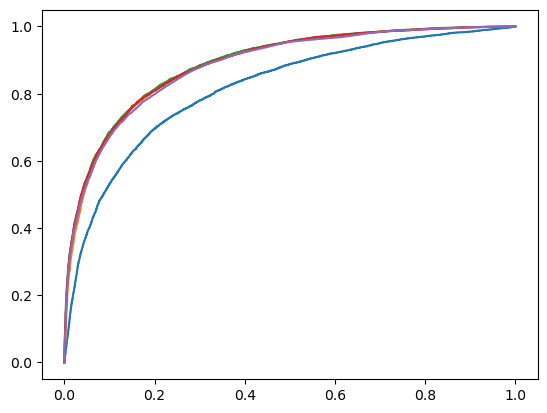

In [17]:
# 4. ÉVALUATION COMPARATIVE
models_results = []                     
print("Modèles qui vont être évalués :", list(best_estimators.keys()))  # pour vérifier

for name, clf in best_estimators.items():
    y_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)
    # Calcul des métriques
    auc_score = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    models_results.append({
        'Modèle': name,
        'AUC-ROC': round(auc_score, 4),
        'Recall (Churn)': round(report['1']['recall'], 4),
        'Precision (Churn)': round(report['1']['precision'], 4),
        'F1-Score': round(report['1']['f1-score'], 4)
    })
    
    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')


===== Logistic Regression =====
              precision    recall  f1-score   support

           0     0.9142    0.7598    0.8299     26023
           1     0.4507    0.7344    0.5586      6984

    accuracy                         0.7544     33007
   macro avg     0.6825    0.7471    0.6943     33007
weighted avg     0.8162    0.7544    0.7725     33007

AUC-ROC: 0.8159
Matrice de confusion (absolue):
[[19773  6250]
 [ 1855  5129]]


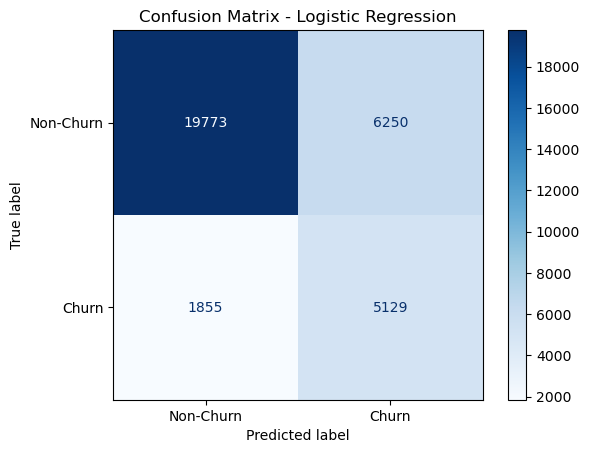


===== Random Forest =====
              precision    recall  f1-score   support

           0     0.9337    0.8300    0.8788     26023
           1     0.5520    0.7804    0.6466      6984

    accuracy                         0.8195     33007
   macro avg     0.7429    0.8052    0.7627     33007
weighted avg     0.8529    0.8195    0.8297     33007

AUC-ROC: 0.8856
Matrice de confusion (absolue):
[[21600  4423]
 [ 1534  5450]]


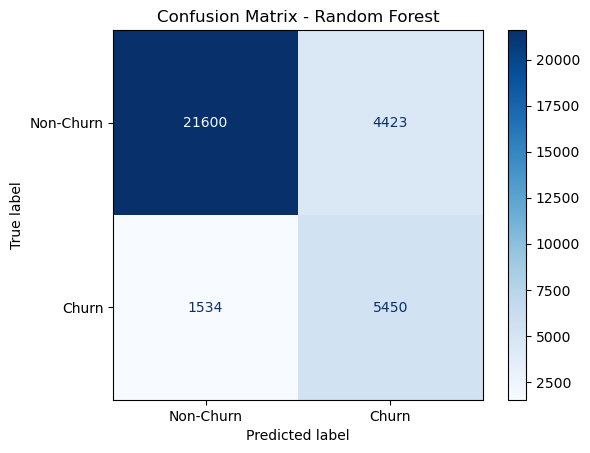


===== XGBoost =====
              precision    recall  f1-score   support

           0     0.9475    0.7674    0.8480     26023
           1     0.4926    0.8416    0.6215      6984

    accuracy                         0.7831     33007
   macro avg     0.7201    0.8045    0.7347     33007
weighted avg     0.8513    0.7831    0.8001     33007

AUC-ROC: 0.8899
Matrice de confusion (absolue):
[[19969  6054]
 [ 1106  5878]]


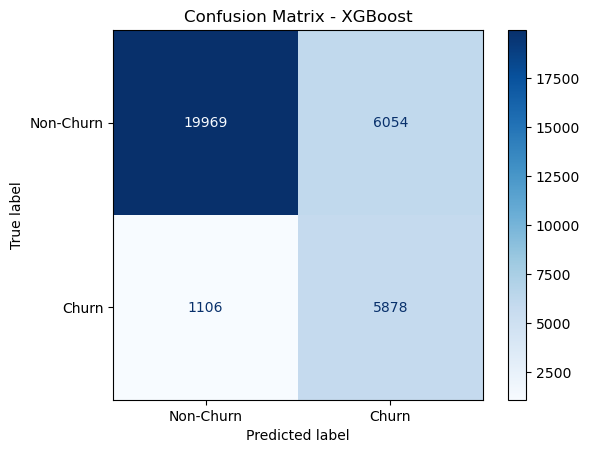


===== Gradient Boosting =====
              precision    recall  f1-score   support

           0     0.9079    0.9117    0.9098     26023
           1     0.6657    0.6555    0.6606      6984

    accuracy                         0.8575     33007
   macro avg     0.7868    0.7836    0.7852     33007
weighted avg     0.8567    0.8575    0.8571     33007

AUC-ROC: 0.8880
Matrice de confusion (absolue):
[[23724  2299]
 [ 2406  4578]]


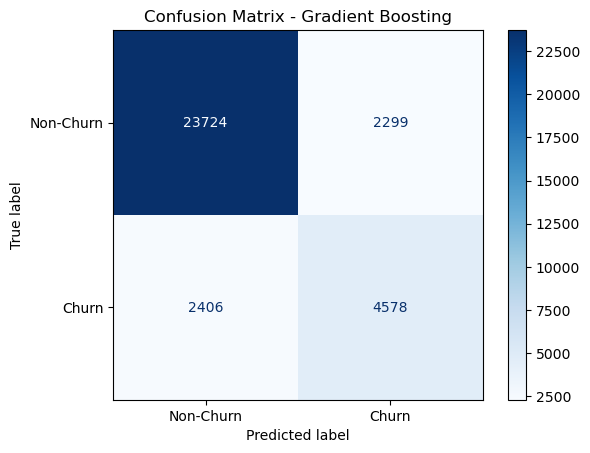


===== Decision Tree =====
              precision    recall  f1-score   support

           0     0.8840    0.9500    0.9159     26023
           1     0.7421    0.5357    0.6222      6984

    accuracy                         0.8624     33007
   macro avg     0.8131    0.7428    0.7690     33007
weighted avg     0.8540    0.8624    0.8537     33007

AUC-ROC: 0.8841
Matrice de confusion (absolue):
[[24723  1300]
 [ 3243  3741]]


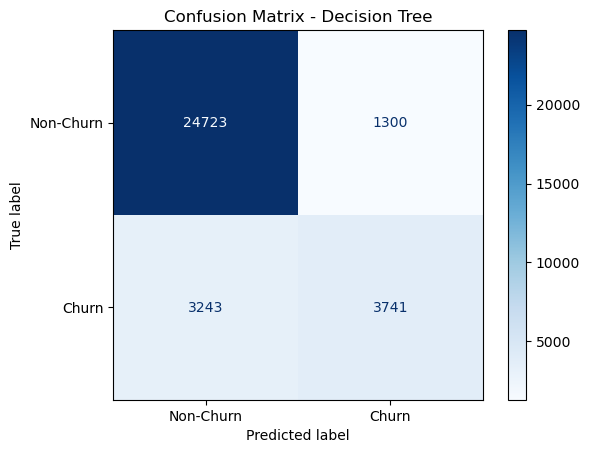

In [18]:
## matrice de confusion
for name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\n===== {name} =====")
    print(classification_report(y_test, y_pred, digits=4))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    print("Matrice de confusion (absolue):")
    print(cm)
    
    disp = ConfusionMatrixDisplay(cm, display_labels=['Non-Churn', 'Churn'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


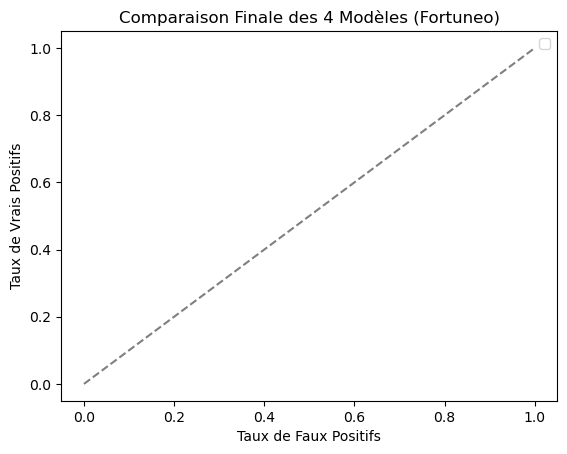

In [19]:
# 5. VISUALISATION DES RÉSULTATS
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title('Comparaison Finale des 4 Modèles (Fortuneo)')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.legend()
plt.show()

In [20]:
df_results = pd.DataFrame(models_results)
print("\n--- TABLEAU COMPARATIF DES PERFORMANCES ---")
print(df_results.sort_values(by='Recall (Churn)', ascending=False))


--- TABLEAU COMPARATIF DES PERFORMANCES ---
                Modèle  AUC-ROC  Recall (Churn)  Precision (Churn)  F1-Score
2              XGBoost   0.8899          0.8416             0.4926    0.6215
1        Random Forest   0.8856          0.7804             0.5520    0.6466
0  Logistic Regression   0.8159          0.7344             0.4507    0.5586
3    Gradient Boosting   0.8880          0.6555             0.6657    0.6606
4        Decision Tree   0.8841          0.5357             0.7421    0.6222


In [21]:
# 6. SAUVEGARDE DU MODÈLE CHAMPION
# Automatiquement, on prend celui qui a le meilleur Recall pour Fortuneo
best_model_name = df_results.sort_values(by='Recall (Churn)', ascending=False).iloc[0]['Modèle']
print(f"\nLe modèle '{best_model_name}' a été sauvegardé comme modèle final.")


Le modèle 'XGBoost' a été sauvegardé comme modèle final.


In [23]:
joblib.dump(best_estimators[best_model_name], 'modele_final_churn.pkl')

['modele_final_churn.pkl']